# training check

In [1]:
import numpy as np
import torch
from dataset_multitask_1d import motask_generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nchannels = 3
in_channels = nchannels



In [2]:
import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# from test_baseline import Convcnp,compute_loss_baseline
# from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# #from test_correlatenp import  CGP_Convnp,compute_loss_gp        
# from test_mocorrelatenp import  CGP_Convnp,compute_loss_gp        

from test_baseline import Convcnp,compute_loss_baseline
from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
from test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  




nsamples_latent=10
#nsamples_gp = 5
nsamples_gp = 10

num_nchannels = 3
lr = 0.001
weight_decay=1e-4
#cnntype = 



#def get_model(modelname='gp'):        
def get_model(modelname='gp',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=num_nchannels,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=3,num_postsamples=nsamples_latent,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    #if modelname == 'gp_ind':
    if modelname == 'gpind':        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=3,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    #if modelname == 'gp_dep':
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=3,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
      
    return model,opt,lossfun


In [4]:
#proposed_model_list =  ['gp','p']

#proposed_model_list = ['gp_ind','gp_dep']
proposed_model_list = ['gpind','gpdep']
def validate_epochs_with_dict(set_dict_epoch,model,lossfun,test_range=None,trainmodel='convcnp'):
    # large is better 
    model.eval()
    likelihoods = []
    
    ntask = set_dict_epoch['context_x'].size(0)    
    for ith in range(ntask):        
        
        context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]        
        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)
                    
        
        
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
        #obj = -compute_nll( y_mean,y_std, target_y.cuda())
        obj = -lossfun( y_mean,y_std, target_y.cuda())
                    
        #if trainmodel in base_model_list:
        #    obj = -compute_nll( y_mean,y_std, target_y.cuda())
        #if trainmodel in latent_model_list:
        #    obj = -compute_nll_latent( y_mean, y_std, target_y.cuda())            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       


## Take models and load params

## load params

In [49]:
# tasktype = 'sin3'
# testtype = 'extra'
# dep = True

# tasktype = 'lmc'
# testtype = 'extra'
# dep = True

#modelname = 'baseline'   #'gp,baseline,baseline_latent'


tasktype = 'sin3'
#tasktype = 'lmc'
#tasktype = 'mosm'

testtype = 'extra'
dep = True


In [50]:
import glob
saved_param_list = glob.glob('./param_{}/*.pth'.format(tasktype))
saved_param_list.sort()
saved_param_list

['./param_sin3/depFalse_extra_gpdep_initl0.1_deep_nsamples10.pth',
 './param_sin3/depFalse_extra_gpind_initl0.1_deep_nsamples10.pth',
 './param_sin3/depFalse_extra_gpind_initl0.1_deep_nsamples5.pth',
 './param_sin3/depFalse_extra_gpind_initl1.0_deep_nsamples5.pth',
 './param_sin3/depTrue_extra_baselatent_initl0.01_deep_baselatent-nsamples10.pth',
 './param_sin3/depTrue_extra_baselatent_initl0.01_deep_nsamples10.pth',
 './param_sin3/depTrue_extra_baselatent_initl0.1_deep_nsamples10.pth',
 './param_sin3/depTrue_extra_gpdep_initl0.1_deep_nsamples10.pth',
 './param_sin3/depTrue_extra_gpdep_initl0.1_deep_nsamples4.pth',
 './param_sin3/depTrue_extra_gpdep_initl0.5_deep_nsamples5.pth',
 './param_sin3/depTrue_extra_gpdep_initl1.0_deep_nsamples10.pth',
 './param_sin3/depTrue_extra_gpdep_initl1.0_deep_nsamples5.pth',
 './param_sin3/depTrue_extra_gpind_initl0.01_deep_nsamples4.pth',
 './param_sin3/depTrue_extra_gpind_initl0.1_deep_nsamples10.pth',
 './param_sin3/depTrue_extra_gpind_initl0.1_deep_

In [51]:
#cnntype = 'shallow' if len(param_detail.split('_')) else 'deep'

In [85]:
#modelname
#target_modelname = None
#target_modelname = ['gpdep']
#target_modelname = ['gpind']
target_modelname = ['base']
#target_modelname = ['baselatent']

In [86]:
#cnntype
#print(param_detail.split('_'))
#saved_modelparam_path

In [87]:
#for modelname in modelnamelist:
for saved_modelparam_path in saved_param_list:   
    _,param_saved,param_detail = saved_modelparam_path.split('/')
    
    #print(param_saved.split('_'))
    #print(param_detail.split('_'))
    
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    #cnntype = 'shallow' if len(param_detail.split('_'))==4 else 'deep'
    #cnntype = param_detail.split('_')[-1].split('.')[0]
    cnntype = param_detail.split('_')[4]
    
    #print(cnntype)
    
    #print(modelname)
    #+'_'+param_detail.split('_')[-2]    
    #if modelname in target_modelname and len(param_detail.split('_'))==5:
    #if modelname in target_modelname and len(param_detail.split('_'))==6:
    if modelname in target_modelname :
        
        #cnntype='deep'
        try:
            model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
            #saved_modelparam_path = './param_{}/dep{}_{}_{}.pth'.format(tasktype,dep,testtype,model.modelname)
            #saved_modelparam_path = './param_{}/dep{}_{}_{}_initl{}.pth'.format(tasktype,dep,testtype,model.modelname,init_lscale)        

            saved_dict = torch.load(saved_modelparam_path)
            model.load_state_dict(saved_dict['state_dict'])


            #saved_dataset_path = './syndata_{}/dep{}_{}_{}'.format(tasktype, dep, testtype, -1)
            saved_dataset_path = './syndata_{}/{}_{}_{}'.format(tasktype, deptype , testtype, -1)

            loaded = torch.load(saved_dataset_path + '.db')
            testset_inrange = loaded['train_set']
            testset_outrange = loaded['valid_set']

            load_dict = torch.load(saved_modelparam_path)
            model.load_state_dict(load_dict['state_dict'])           
            testin_loss_mean,testin_loss_std  = validate_epochs_with_dict( testset_inrange,model,lossfun )
            testout_loss_mean,testout_loss_std  = validate_epochs_with_dict( testset_outrange,model,lossfun )  

            print('{}: \t intest mnll: {:.2f} ({:.2f}), \t outtest mnll: {:.2f} ({:.2f}) \t saved at {}'.format(saved_modelparam_path,testin_loss_mean,testin_loss_std,testout_loss_mean,testout_loss_std,saved_dict['epoch']))       

        except:
            pass

    
    #print('model.num_params: {}'.format(model.num_params))
    

In [79]:
model.num_samples

10

In [80]:
model.compute_regloss_terms()

0.0

## gp baseline

In [81]:
# from test_gpbaseline import GP_Baseline
# gp_base = GP_Baseline(in_dims=1,out_dims=1,num_channels=3,kerneltype=tasktype,dep=dep)

# saved_dataset_path = './syndata_{}/dep{}_{}_{}'.format(tasktype, dep, testtype, -1)
# loaded = torch.load(saved_dataset_path + '.db')
# testset_inrange = loaded['train_set']
# testset_outrange = loaded['valid_set']

# in_full,in_diag = gp_base.compute_logprob_task(testset_inrange)
# out_full,out_diag = gp_base.compute_logprob_task(testset_outrange)


# print('loaded data: {}'.format(saved_dataset_path))
# print('full gp')
# print('intest mnll: {:.2f} ({:.2f}), \t outtest mnll: {:.2f} ({:.2f})'.format(in_full[0],in_full[1],out_full[0],out_full[1]))       
# print('diag gp')
# print('intest mnll: {:.2f} ({:.2f}), \t outtest mnll: {:.2f} ({:.2f})'.format(in_diag[0],in_diag[1],out_diag[0],out_diag[1]))       
# print('')



In [82]:

# init_lscale=0.01
# dep=False
# cnntype='deep'

## load dataset and fitting check

In [117]:
#saved_modelparam_path = './param_mosm/depFalse_extra_gpdep_initl0.1_deep_nsamples10.pth'
saved_modelparam_path = './param_mosm/depTrue_extra_gpdep_initl0.1_deep_nsamples10.pth'


_,param_saved,param_detail = saved_modelparam_path.split('/')
tasktype = param_saved.split('_')[1]
deptype = param_detail.split('_')[0]
modelname = param_detail.split('_')[2]
cnntype = param_detail.split('_')[4]


#print(tasktype,deptype,modelname,cnntype)

model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
#saved_modelparam_path = './param_{}/dep{}_{}_{}.pth'.format(tasktype,dep,testtype,model.modelname)
#saved_modelparam_path = './param_{}/dep{}_{}_{}_initl{}.pth'.format(tasktype,dep,testtype,model.modelname,init_lscale)        

saved_dict = torch.load(saved_modelparam_path)
model.load_state_dict(saved_dict['state_dict'])

print(tasktype,deptype,modelname,cnntype)

mosm depTrue gpdep deep


## datasets

In [118]:
#dep=True

In [119]:
#tasktype = 'sin3'
#tasktype = 'mosm'
#dep=False
i=-1


dep=True if deptype == 'depTrue' else False
save_path_set = './syndata_{}/dep{}_{}_{}'.format(tasktype, dep, testtype, i)
loaded = torch.load(save_path_set + '.db')


In [120]:
#pstd_xt
import matplotlib.pyplot as plt
delta = 1.0
y_ = 5
xlim_=[0-delta,6+delta]
ylim_=[-y_-delta,y_+delta]

figsiz_=(15,3*3)
color_list = ['r','b','g']
predicted_model_list = ['gpind','gpdep','baselatent']

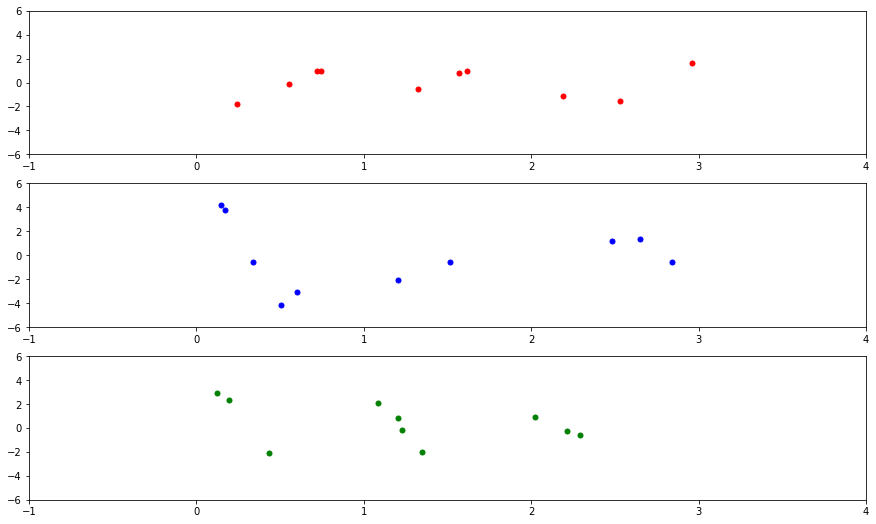

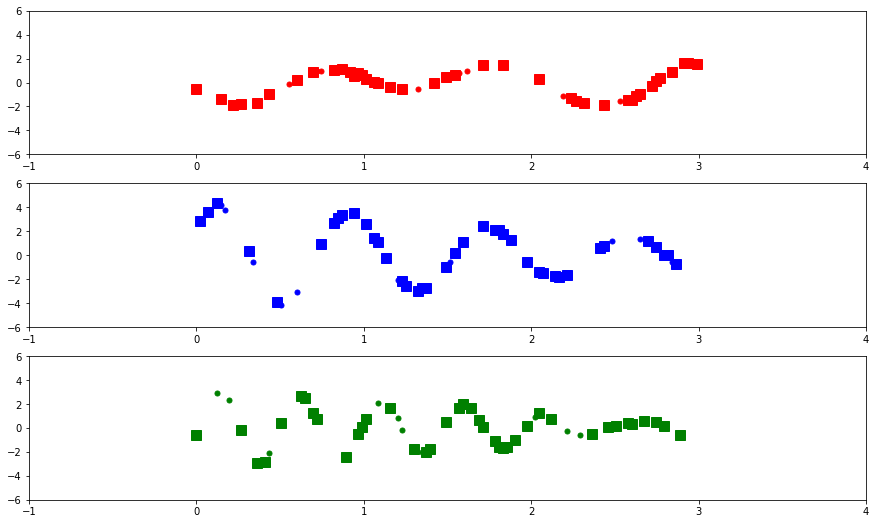







predict


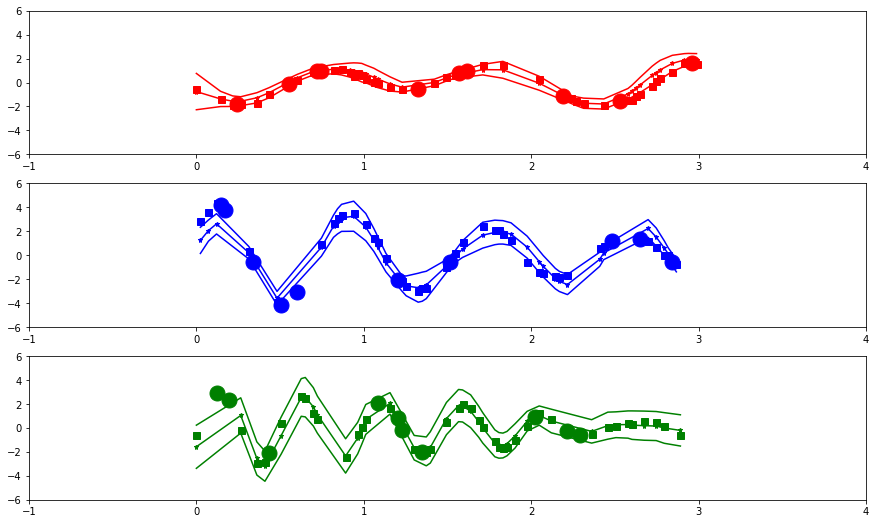

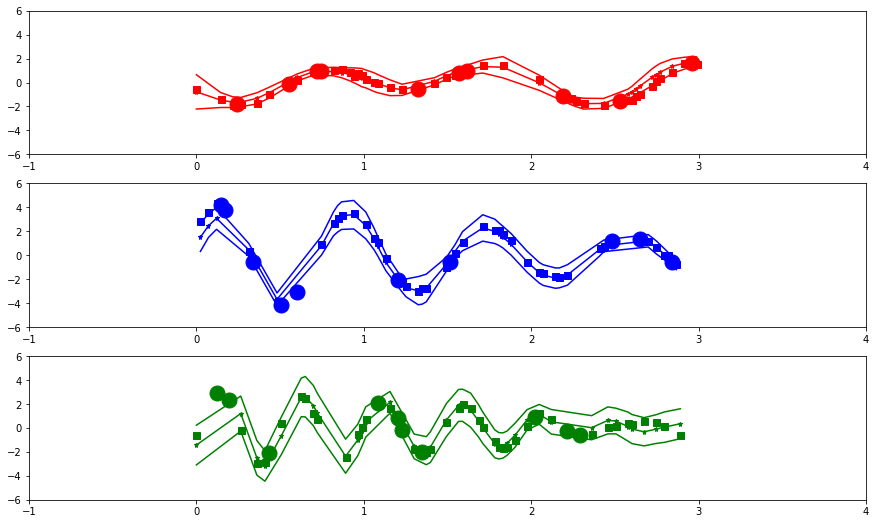

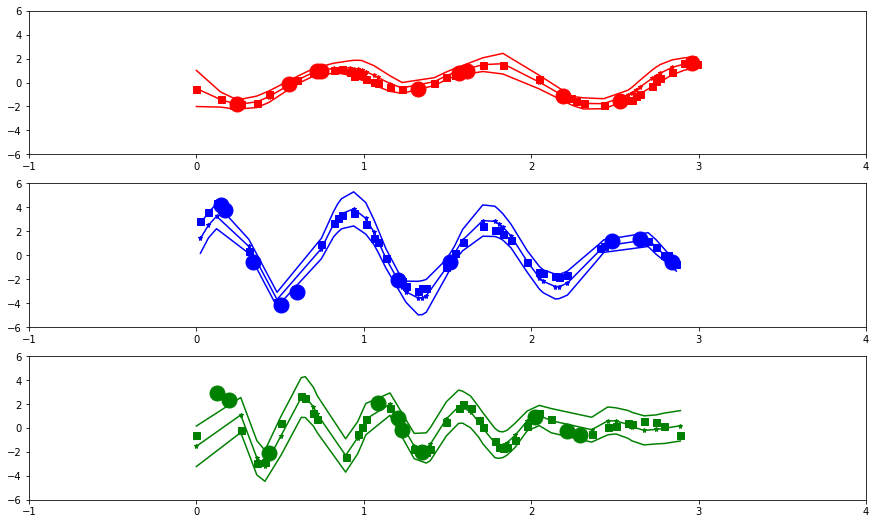

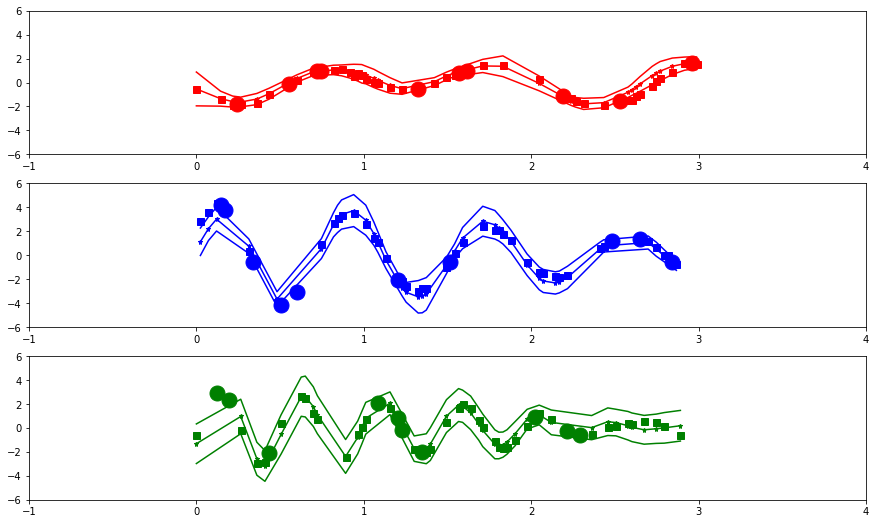

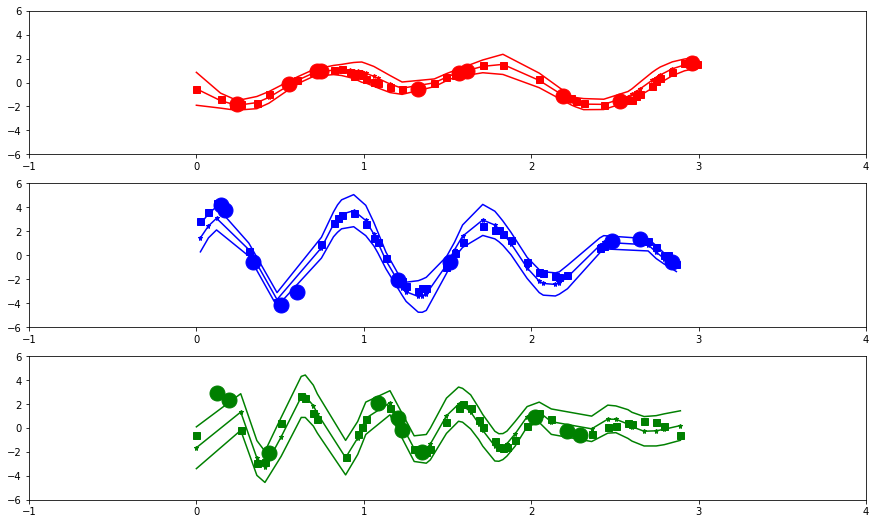

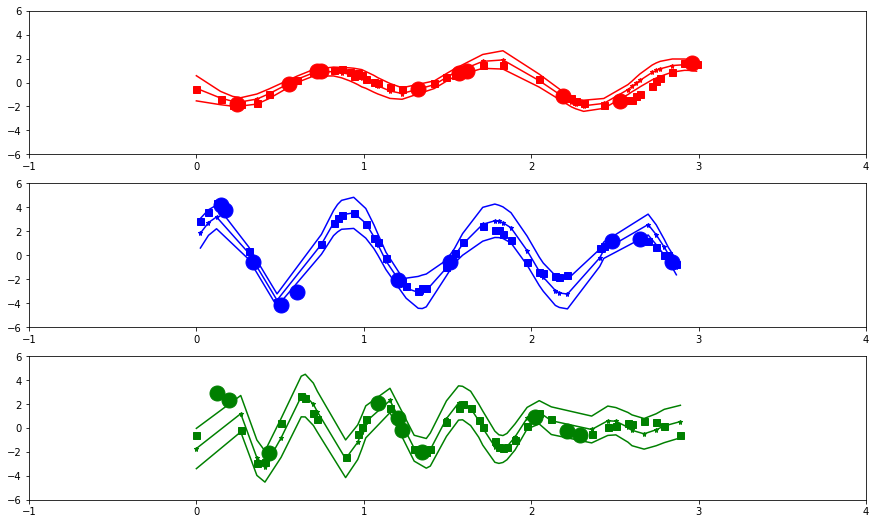

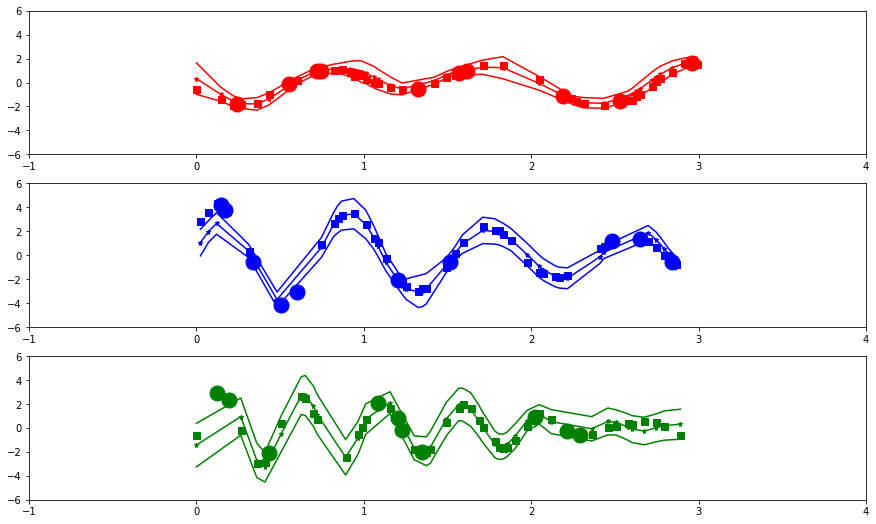

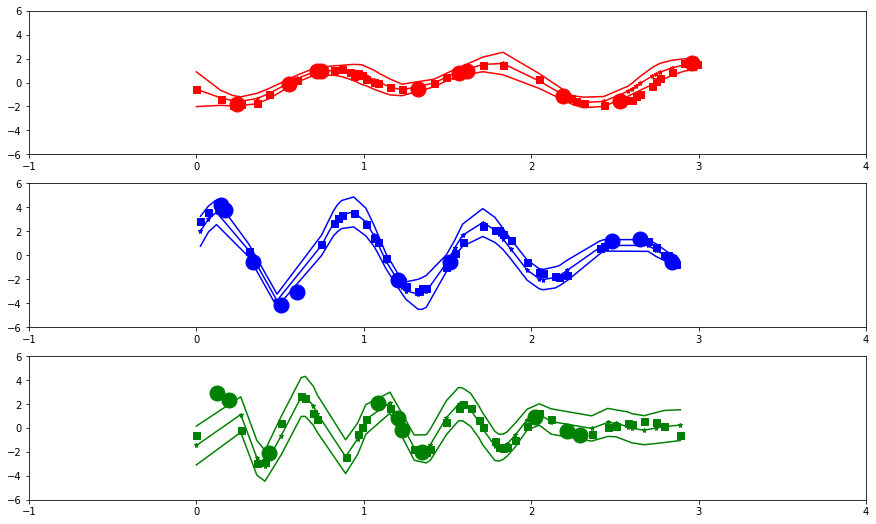

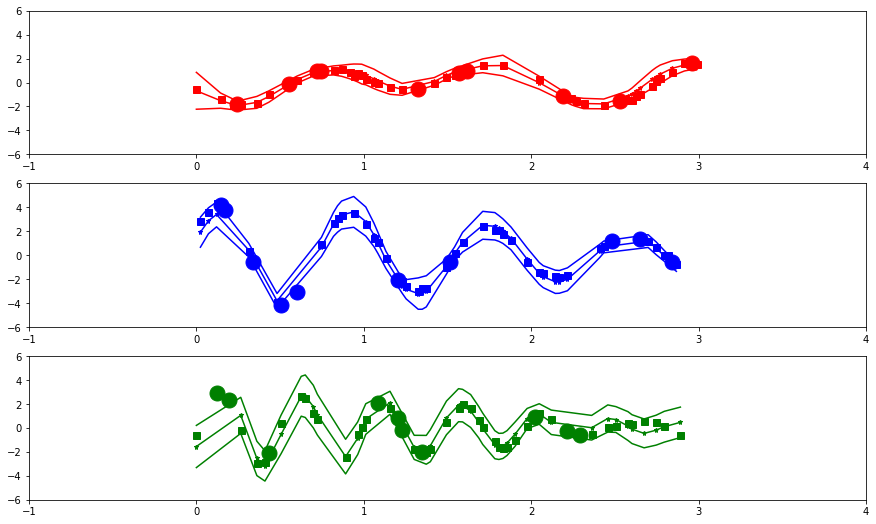

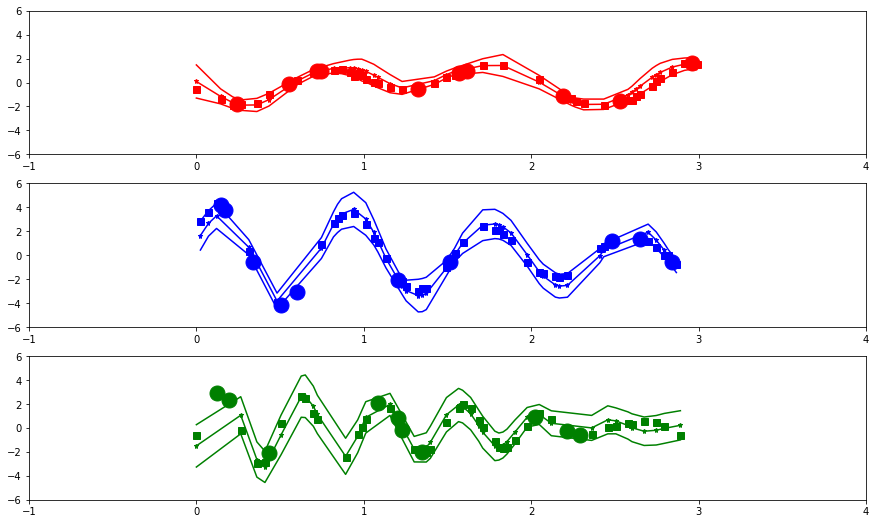

In [121]:
#idx = 7
idx = 8

xlim_=[0-delta,3+delta]
ylim_=[-y_-delta,y_+delta]


train_set = loaded['train_set']
#train_set = loaded['valid_set']

xc = train_set['context_x'][idx][...,None,:]
yc = train_set['context_y'][idx]
xt = train_set['target_x'][idx][...,None,:]
yt = train_set['target_y'][idx]


model.eval()
if model.modelname in proposed_model_list:
    pmu_xt,pstd_xt = model(xc.cuda(),yc.cuda(),xt.cuda())       
else:
    pmu_xt,pstd_xt = model(xc.squeeze().cuda(),yc.cuda(),xt.squeeze().cuda())       

    
    
    
    
    

fig=plt.figure(figsize=figsiz_)
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    #plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=5)    
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)                
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    
    #plt.yticks([-5-1,5+1])    
plt.show()




fig=plt.figure(figsize=figsiz_)
color_list = ['r','b','g']
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    #plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=5)    
    plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=10)                
    plt.xlim(xlim_)
    plt.ylim(ylim_)
plt.show()



print('\n'*5)
print('predict')


color_list = ['r','b','g']
if model.modelname in predicted_model_list:
    for j in range(model.num_samples):
        fig=plt.figure(figsize=figsiz_)
        for i in range(nchannels):
            plt.subplot(3,1,i+1)
            plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=15)    
            plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=7)                

        #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=10)
        #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')
        #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')

#             plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,j,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=10)
#             plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,j,:,i].cpu().data.numpy(),color_list[i]+'-')
#             plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,j,:,i].cpu().data.numpy(),color_list[i]+'-')

            plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[j,0,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=5)
            plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),color_list[i]+'-')
            plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),color_list[i]+'-')

            plt.xlim(xlim_)
            plt.ylim(ylim_)

        plt.show()
        print('\n'*3)
        
else:
    fig=plt.figure(figsize=figsiz_)
    for i in range(nchannels):
        plt.subplot(3,1,i+1)
        plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=15)    
        plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=7)                

    #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=10)
    #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')
    #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')

        plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'d-',markersize=7)
        plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')
        plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')

        plt.xlim(xlim_)
        plt.ylim(ylim_)

    plt.show()
    

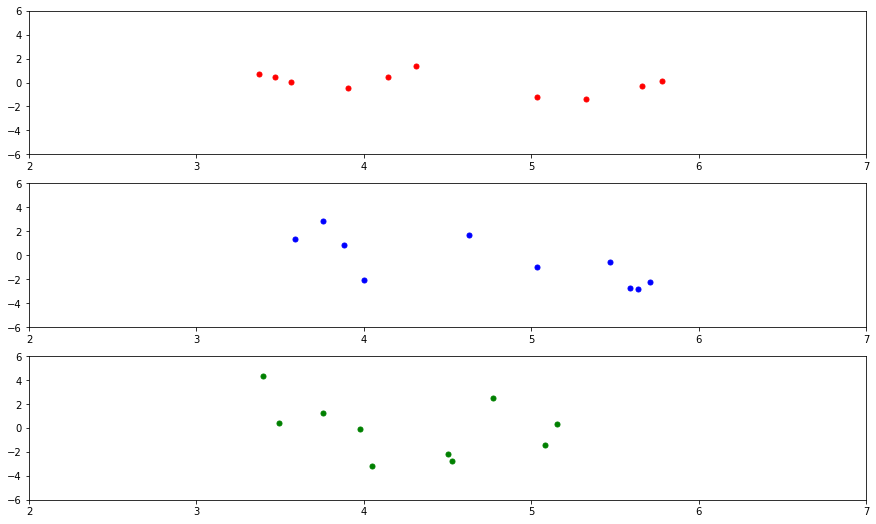

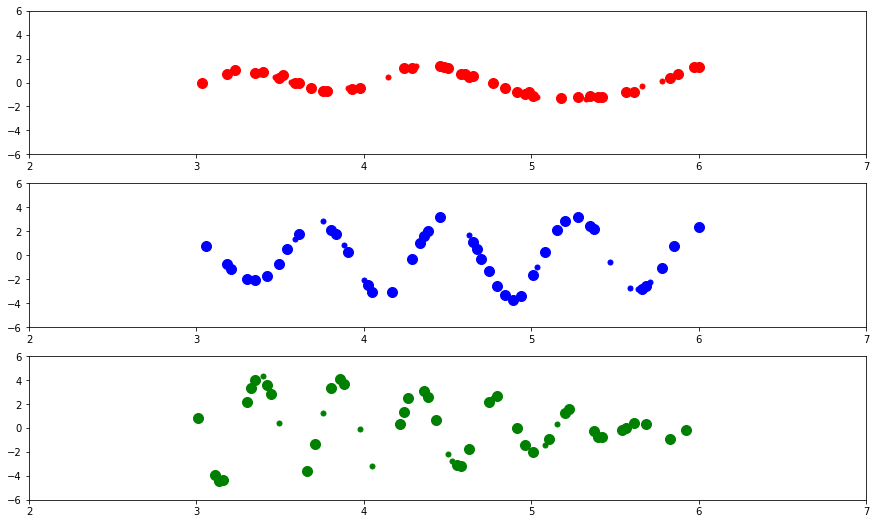







predict


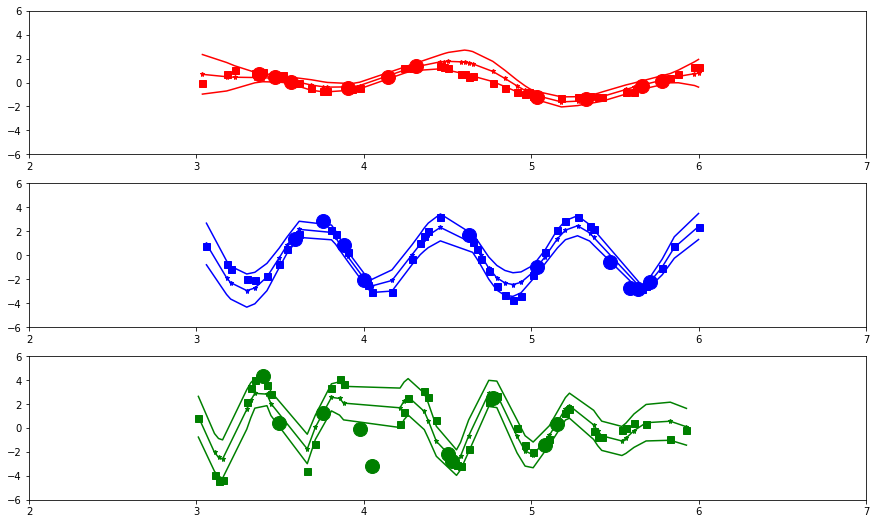

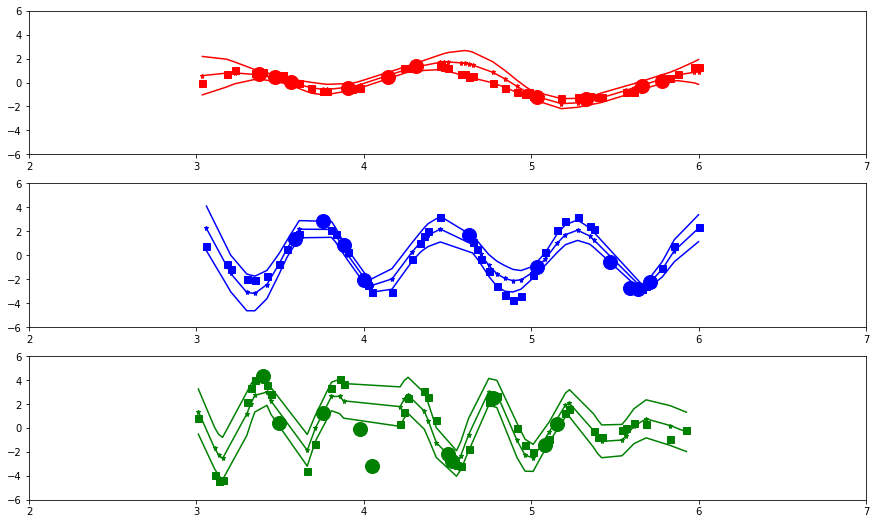

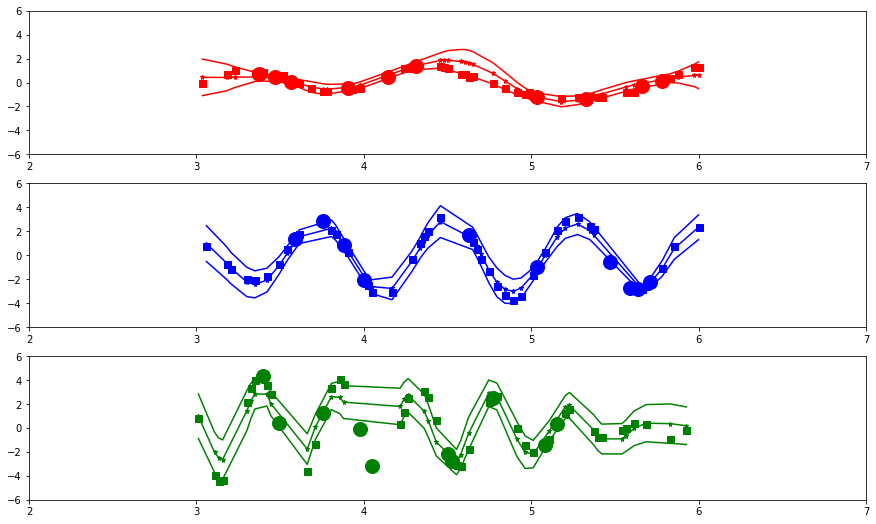

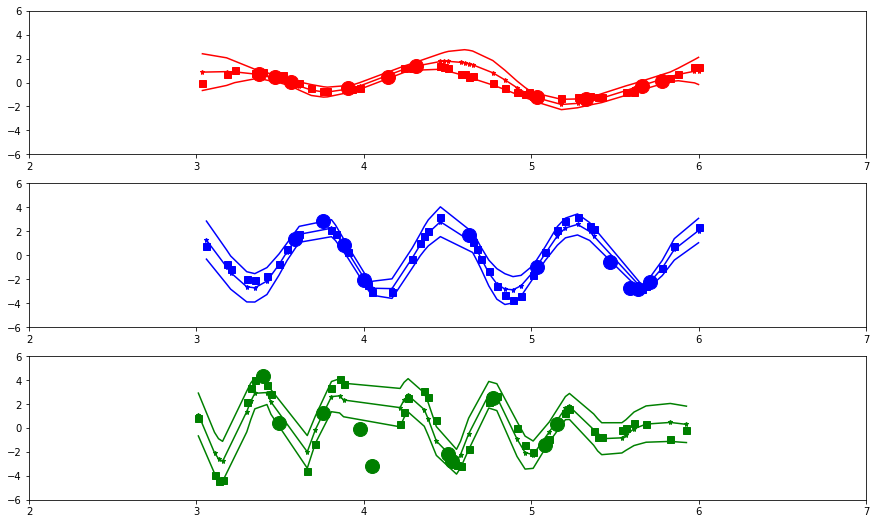

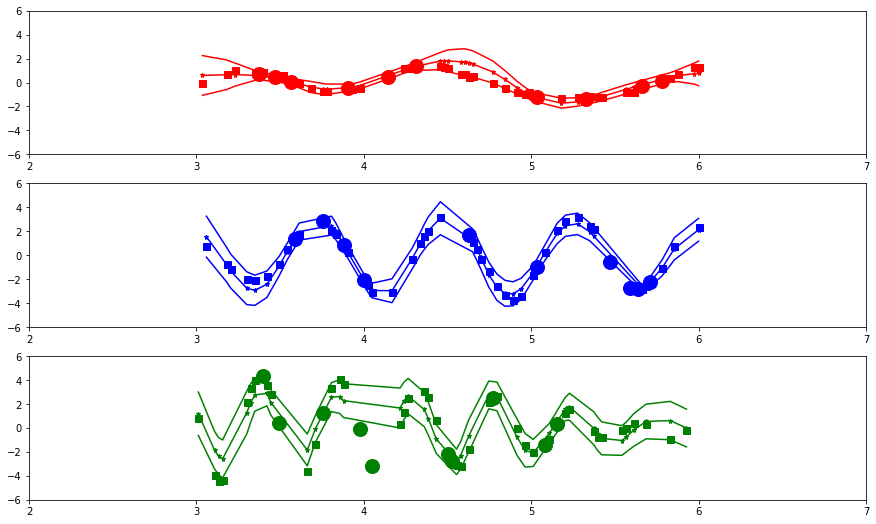

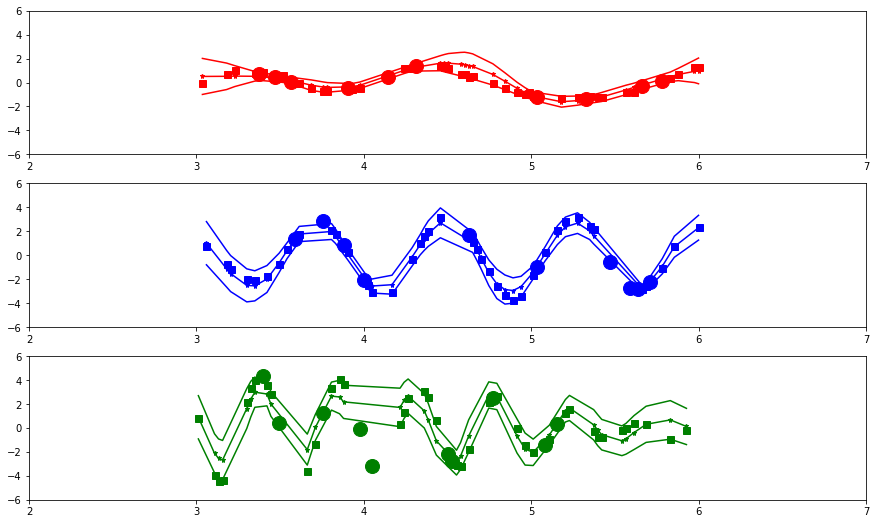

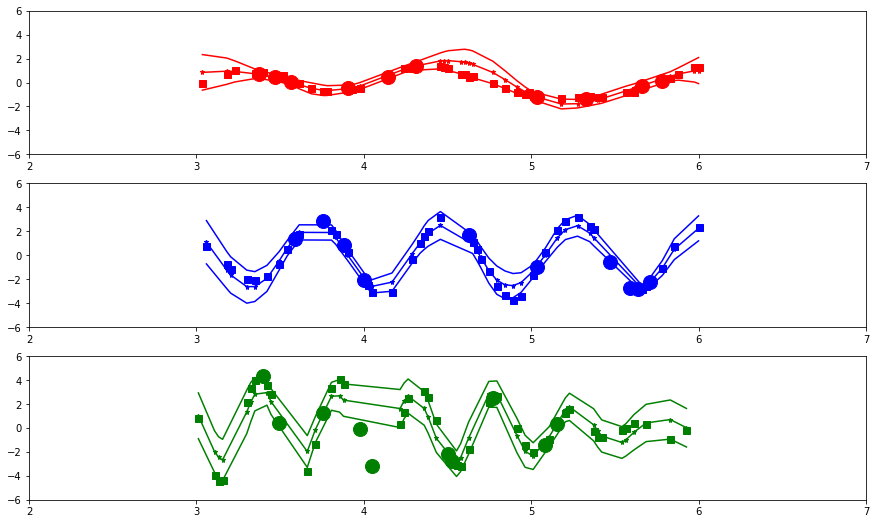

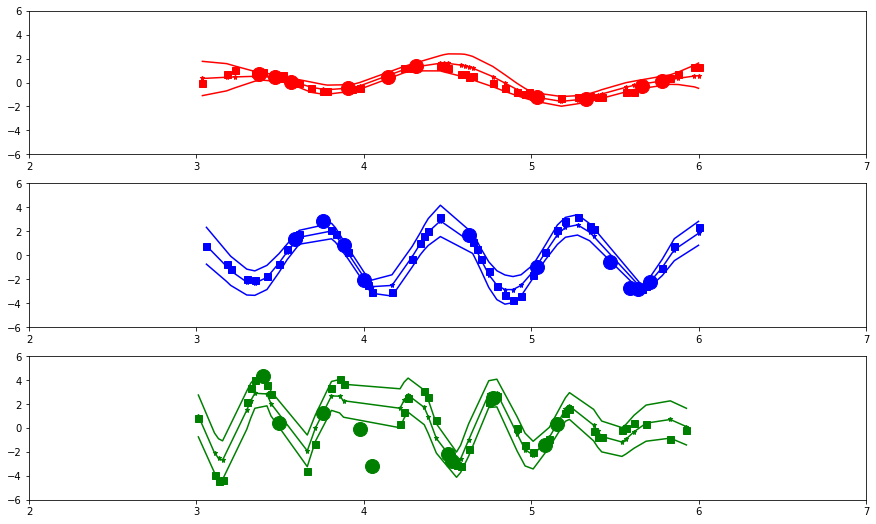

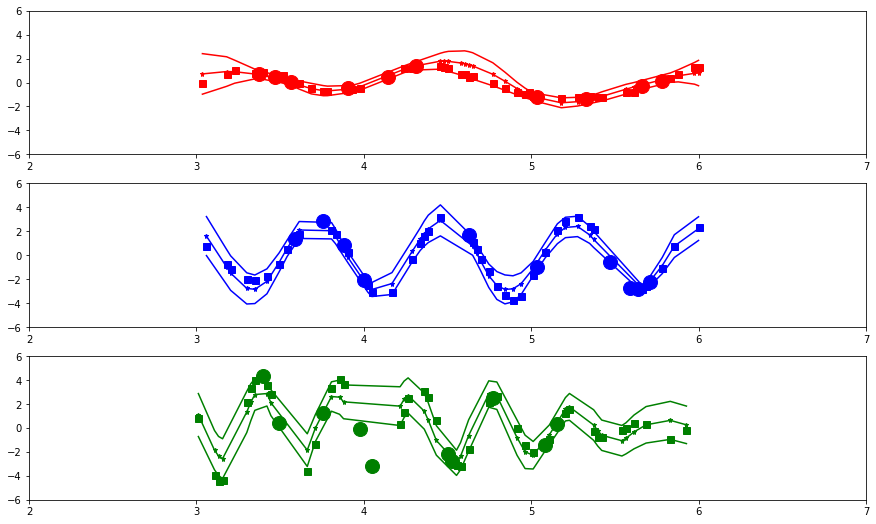

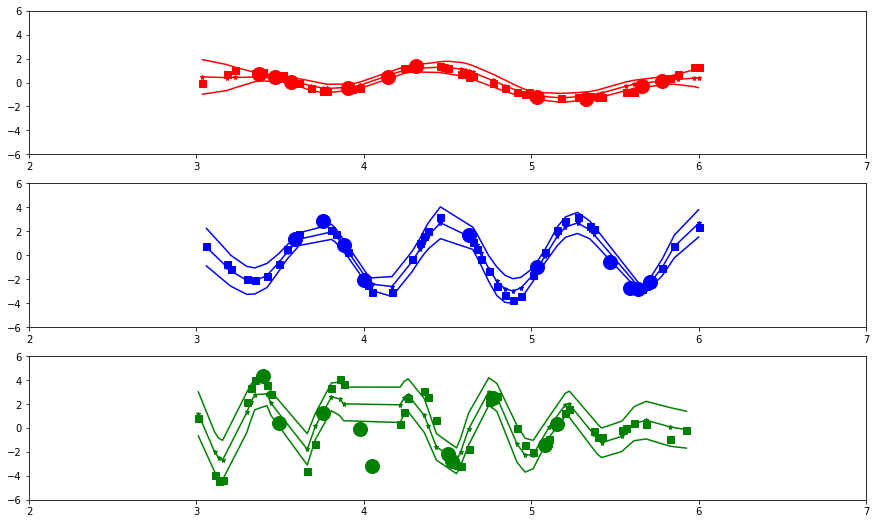

In [122]:

# import matplotlib.pyplot as plt
# delta = 0.2
# xlim_=[0-delta,6+delta]
# ylim_=[-7-delta,7+delta]
# figsiz_=(15,3*3)
# color_list = ['r','b','g']

xlim_=[3-delta,6+delta]
ylim_=[-y_-delta,y_+delta]


train_set = loaded['valid_set']

xc = train_set['context_x'][idx][...,None,:]
yc = train_set['context_y'][idx]
xt = train_set['target_x'][idx][...,None,:]
yt = train_set['target_y'][idx]
model.eval()
if model.modelname in proposed_model_list:
    pmu_xt,pstd_xt = model(xc.cuda(),yc.cuda(),xt.cuda())       
    #model.num_postsamples = numsamples    
else:
    pmu_xt,pstd_xt = model(xc.squeeze().cuda(),yc.cuda(),xt.squeeze().cuda())       




fig=plt.figure(figsize=figsiz_)
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    #plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=5)    
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)                
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    
    #plt.yticks([-5-1,5+1])    
plt.show()



#figsiz_=(15,3*3)
fig=plt.figure(figsize=figsiz_)
color_list = ['r','b','g']
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    #plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=5)    
    plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)                
    plt.xlim(xlim_)
    plt.ylim(ylim_)
plt.show()

print('\n'*5)
print('predict')






# print(xc.size(),xt.size())
# model.eval()
# if model.modelname in ['p','gp']:
#     pmu_xt,pstd_xt = model(xc.cuda(),yc.cuda(),xt.cuda())       
# else:
#     pmu_xt,pstd_xt = model(xc.squeeze().cuda(),yc.cuda(),xt.squeeze().cuda())       

# pmu_xt.size(),pstd_xt.size()


color_list = ['r','b','g']

if model.modelname in predicted_model_list:
    for j in range(model.num_samples):
        fig=plt.figure(figsize=figsiz_)
        for i in range(nchannels):
            plt.subplot(3,1,i+1)
            plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=14)    
            plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=7)                

        #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=10)
        #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')
        #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')

#             plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,j,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=10)
#             plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,j,:,i].cpu().data.numpy(),color_list[i]+'-')
#             plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,j,:,i].cpu().data.numpy(),color_list[i]+'-')

            plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[j,0,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=5)
            plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),color_list[i]+'-')
            plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),color_list[i]+'-')

            plt.xlim(xlim_)
            plt.ylim(ylim_)

        plt.show()
        print('\n'*3)
        
else:
    fig=plt.figure(figsize=figsiz_)
    for i in range(nchannels):
        plt.subplot(3,1,i+1)
        plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=14)    
        plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=7)                

    #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=10)
    #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')
    #     plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')

        plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'*-',markersize=5)
        plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')
        plt.plot(xt[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'-')

        plt.xlim(xlim_)
        plt.ylim(ylim_)

    plt.show()
    

In [123]:
weight_=model.gpsampler.kernel.logweight.exp()

In [124]:
torch.sqrt(weight_[0]),torch.sqrt(weight_[0]*weight_[1]),torch.sqrt(weight_[0]*weight_[2])

(tensor(0.1251, device='cuda:0', grad_fn=<SqrtBackward0>),
 tensor(0.0087, device='cuda:0', grad_fn=<SqrtBackward0>),
 tensor(0.0083, device='cuda:0', grad_fn=<SqrtBackward0>))

In [125]:
model.gpsampler.kernel.logmu.exp()

tensor([[0.0008, 0.0005, 0.0008]], device='cuda:0', grad_fn=<ExpBackward0>)

In [126]:
#model.gpsampler.kernel.prepare_cross_params()
model.gpsampler.kernel.logstd.exp()

tensor([[0.1425, 0.1498, 0.1732]], device='cuda:0', grad_fn=<ExpBackward0>)

In [127]:
model.gpsampler.kernel.prepare_cross_params()

(tensor([[0.0008, 0.0007, 0.0008, 0.0007, 0.0005, 0.0007, 0.0008, 0.0007, 0.0008]],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>),
 tensor([[7.0180, 3.4208, 3.1673, 3.4208, 6.6739, 3.0953, 3.1673, 3.0953, 5.7726]],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.1251, 0.0027, 0.0025, 0.0027, 0.0697, 0.0014, 0.0025, 0.0014, 0.0664]],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>))

## sample path

In [128]:
#idx = 6
#numsamples = 5

In [129]:
#pstd_xt
#import matplotlib.pyplot as plt
delta = 1.0
y_ = 4
figsiz_=(15,6*nchannels)
color_list = ['r','b','g']
#predicted_model_list = ['gpind','gpdep','baselatent']



In [130]:
numsamples=5

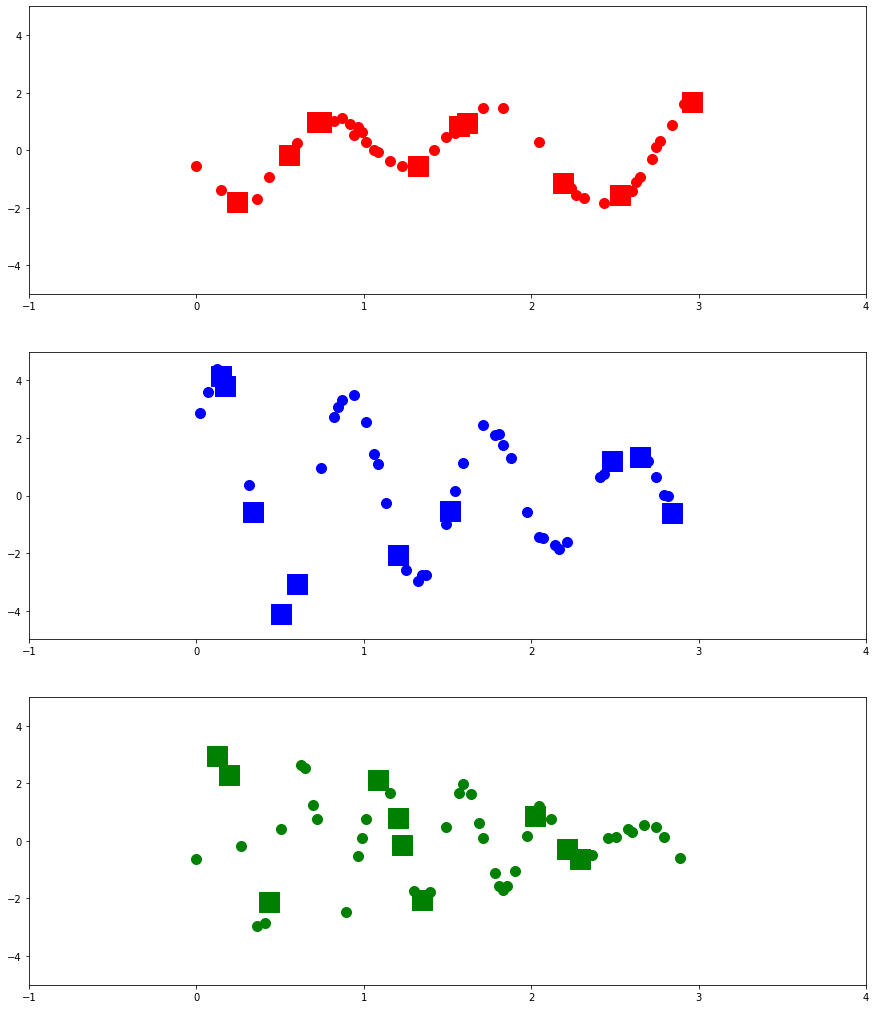

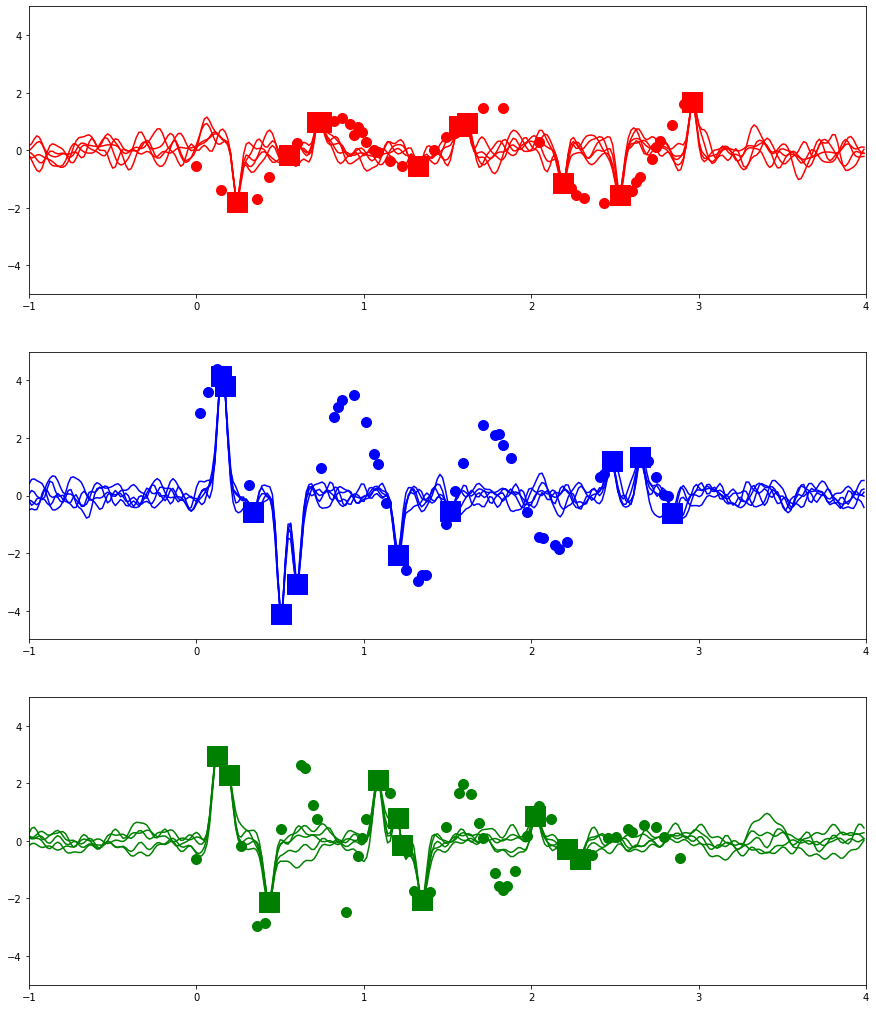

In [131]:
xlim_=[0-delta,3+delta]
ylim_=[-y_-delta,y_+delta]




train_set = loaded['train_set']
xc = train_set['context_x'][idx][...,None,:]
yc = train_set['context_y'][idx]
xt = train_set['target_x'][idx][...,None,:]
yt = train_set['target_y'][idx]


xa,post_samples,density,yc_samples = model.gpsampler.sample_posterior(xc.cuda(),yc.cuda(),xt.cuda(),numsamples=numsamples,reorder=True)
post_mean = post_samples.mean(dim=1)
post_std = post_samples.std(dim=1)



#figsiz_=(15,3*nchannels)
plt.figure(figsize=figsiz_)
color_list = ['r','b','g']
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=20)     
    plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    
    #plt.plot(xa[0,:,0].cpu().data.numpy(),prior_samples[0,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=3)            
    
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'s-')
    plt.xlim(xlim_)
    plt.ylim(ylim_)
plt.show()


plt.figure(figsize=figsiz_)
color_list = ['r','b','g']
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=20)     
    plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    
    for j in range(numsamples):
        #plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=2)        
        plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i])        

    plt.xlim(xlim_)
    plt.ylim(ylim_)
plt.show()



In [132]:
# delta = 1.0
# y_ = 4
# xlim_=[3-delta,6+delta]
# ylim_=[-y_-delta,y_+delta]


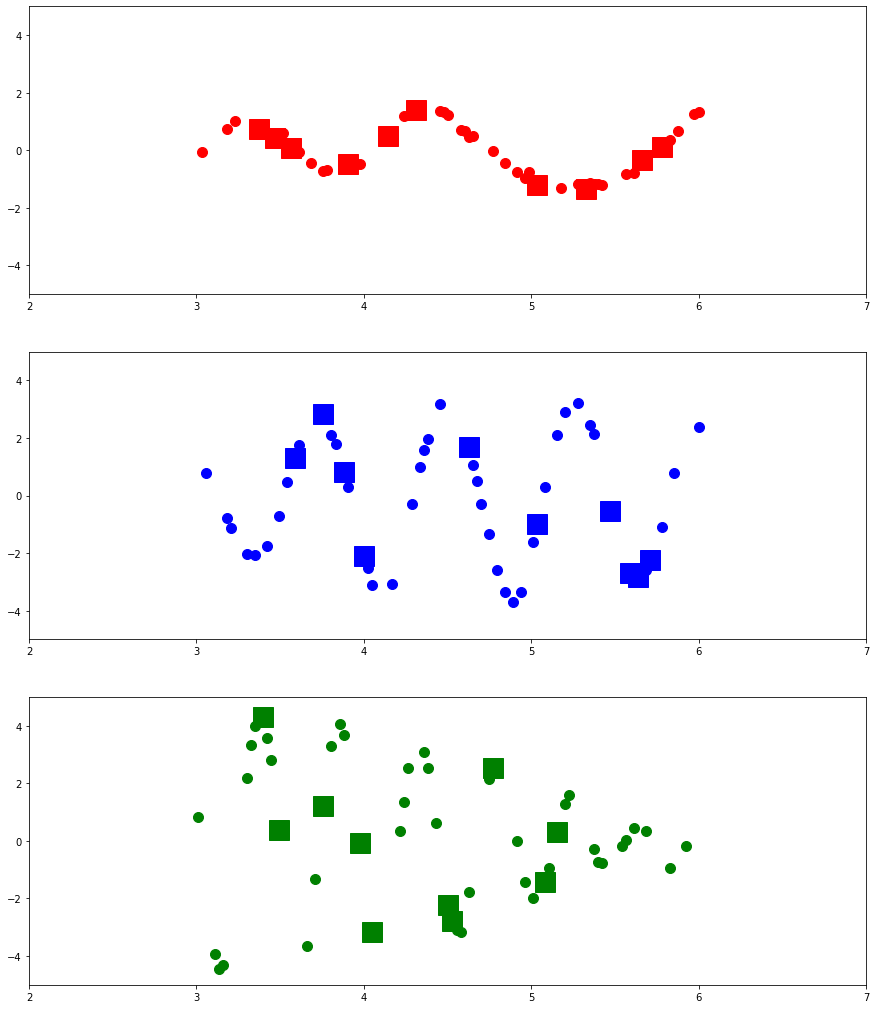

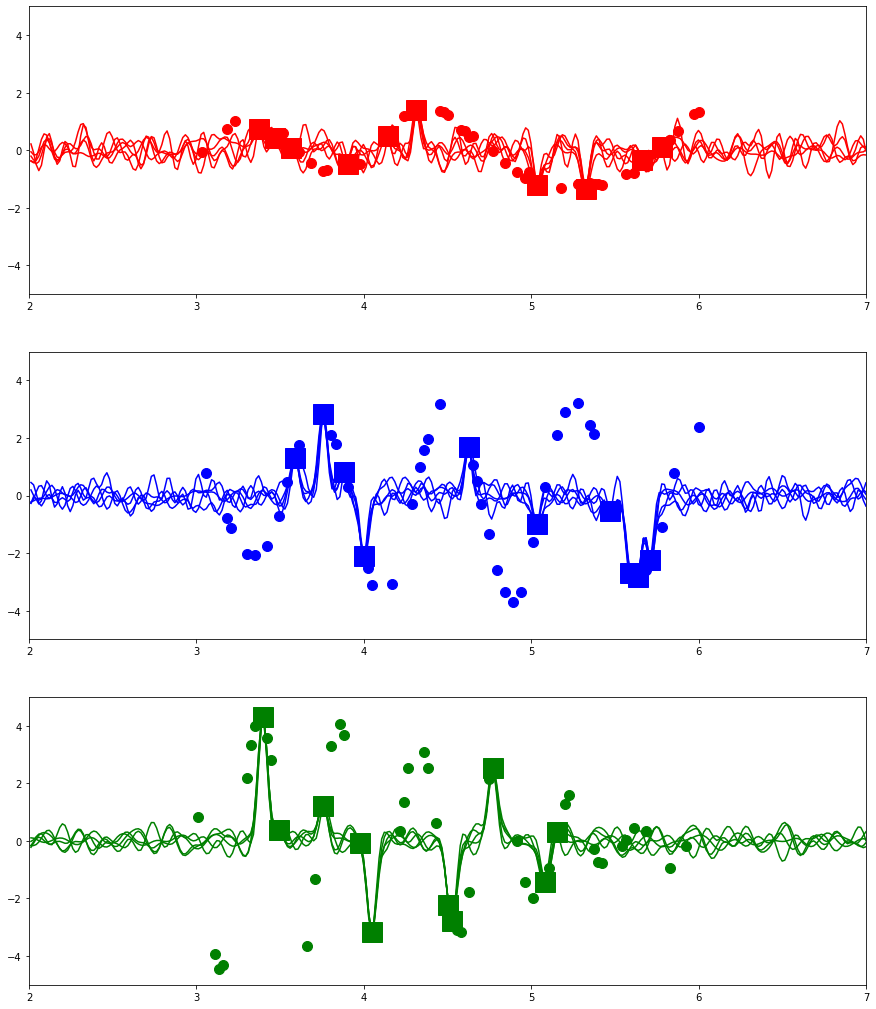

In [133]:
xlim_=[3-delta,6+delta]
ylim_=[-y_-delta,y_+delta]




train_set = loaded['valid_set']
xc = train_set['context_x'][idx][...,None,:]
yc = train_set['context_y'][idx]
xt = train_set['target_x'][idx][...,None,:]
yt = train_set['target_y'][idx]

xa,post_samples,density,yc_samples = model.gpsampler.sample_posterior(xc.cuda(),yc.cuda(),xt.cuda(),numsamples=numsamples,reorder=True)
post_mean = post_samples.mean(dim=1)
post_std = post_samples.std(dim=1)





plt.figure(figsize=figsiz_)
color_list = ['r','b','g']
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10) 
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=20)     
    plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    
    #plt.plot(xa[0,:,0].cpu().data.numpy(),prior_samples[0,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=3)            
    
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'s-')
    plt.xlim(xlim_)
    plt.ylim(ylim_)
plt.show()


plt.figure(figsize=figsiz_)
color_list = ['r','b','g']
for i in range(nchannels):
    plt.subplot(3,1,i+1)
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    #plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)      
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=20)     
    plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)        
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    for j in range(numsamples):
        #plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=2)        
        plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i])        

    plt.xlim(xlim_)
    plt.ylim(ylim_)
plt.show()

In [134]:
#saved_modelparam_path = './param_sin3/depTrue_extra_gpind_initl0.1_deep_nsamples5.pth'
#saved_modelparam_path = './param_sin3/depTrue_extra_gpind_initl1.0_deep_nsamples5.pth'
#saved_modelparam_path = './param_sin3/depTrue_extra_baselatent_initl0.1_deep_nsamples20.pth'
#saved_modelparam_path = './param_sin3/depTrue_extra_baselatent_initl0.1_deep_nsamples10.pth'
#saved_modelparam_path =  './param_lmc/depTrue_extra_gpind_initl0.1_deep_nsamples10.pth'

datatype = 'mosm'
saved_modelparam_depfalse_path = './param_{}/depFalse_extra_gpdep_initl0.1_deep_nsamples10.pth'.format(datatype)
saved_modelparam_deptrue_path = './param_{}/depTrue_extra_gpdep_initl0.1_deep_nsamples10.pth'.format(datatype)


_,param_saved,param_detail = saved_modelparam_depfalse_path.split('/')
tasktype = param_saved.split('_')[1]
dep=True if deptype == 'depTrue' else False

deptype = param_detail.split('_')[0]
modelname = param_detail.split('_')[2]
cnntype = param_detail.split('_')[4]


#print(tasktype,deptype,modelname,cnntype)

model_depfalse,_,_ =  get_model(modelname=modelname,cnntype=cnntype)
saved_dict = torch.load(saved_modelparam_depfalse_path)
model_depfalse.load_state_dict(saved_dict['state_dict'])
print(tasktype,deptype,modelname,cnntype)


print('\n\n')


_,param_saved,param_detail = saved_modelparam_deptrue_path.split('/')
tasktype = param_saved.split('_')[1]
dep=True if deptype == 'depTrue' else False

deptype = param_detail.split('_')[0]
modelname = param_detail.split('_')[2]
cnntype = param_detail.split('_')[4]


#print(tasktype,deptype,modelname,cnntype)

model_deptrue,_,_ =  get_model(modelname=modelname,cnntype=cnntype)
saved_dict = torch.load(saved_modelparam_deptrue_path)
model_deptrue.load_state_dict(saved_dict['state_dict'])
print(tasktype,deptype,modelname,cnntype)

mosm depFalse gpdep deep



mosm depTrue gpdep deep


In [135]:
model_depfalse.gpsampler.kernel.prepare_cross_params()

(tensor([[0.0009, 0.0010, 0.0011, 0.0010, 0.0012, 0.0014, 0.0011, 0.0014, 0.0016]],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>),
 tensor([[6.3810, 2.0799, 1.3414, 2.0799, 3.0857, 1.0954, 1.3414, 1.0954, 1.6984]],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.1167, 0.0028, 0.0023, 0.0028, 0.0882, 0.0016, 0.0023, 0.0016, 0.0872]],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>))

In [136]:
model_deptrue.gpsampler.kernel.prepare_cross_params()

(tensor([[0.0008, 0.0007, 0.0008, 0.0007, 0.0005, 0.0007, 0.0008, 0.0007, 0.0008]],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>),
 tensor([[7.0180, 3.4208, 3.1673, 3.4208, 6.6739, 3.0953, 3.1673, 3.0953, 5.7726]],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.1251, 0.0027, 0.0025, 0.0027, 0.0697, 0.0014, 0.0025, 0.0014, 0.0664]],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>))